# Tire Strategy calculator

This notebook is dedicated to the creation of a calculator of tire degradation. It is inspired by the work of 'Part Time Analyst' on the R-bloggers website. The original article can be found here: https://www.r-bloggers.com/2021/09/f1-strategy-analysis/

The goal of race strategy is to minimize the racetime by choosing the right tire strategy. The tire strategy is a sequence of pitstops, where the driver changes the tires.

First I'll be setting up constants of an hypothetical race

In [4]:
import pandas as pd
from matplotlib import pyplot as plt


In [285]:
# All the time units are in seconds
BASE_LAPTIME = 95 # Optimal laptime obtainable disregarding fuel load, tyre compound and wear
FUEL_PENALTY_PER_LAP = 0.06 # Penalty in seconds per lap for each kg of fuel in the car

NB_LAPS = 70 # Number of laps in the race
STARTING_FUEL = 110 # Starting fuel in kg
FUEL_USAGE_PER_LAP = STARTING_FUEL / NB_LAPS # Fuel usage per lap in kg

TIME_LOST_IN_PIT = 25 # Time lost in the pit in seconds
TIME_LOST_IN_PIT_SAFTY_CAR = 15 # Time lost in the pit in seconds during safety car

SOFT_TYRE = {
    'name' : 'soft',
    'performance_delta': 0, # Performance delta compared to the base laptime
    'degradation_rate': 0.2, # Degradation rate per lap
    'degradation_rate_change': 0.1, # Change in degradation rate per lap
}

MEDIUM_TYRE = {
    'name' : 'medium',
    'performance_delta': 0.75,
    'degradation_rate': 0.08,
    'degradation_rate_change': 0.08,
}

HARD_TYRE = {
    'name' : 'hard',
    'performance_delta': 1.5,
    'degradation_rate': 0.06,
    'degradation_rate_change': 0.07,
}

COMPOUNDS = {
    'soft': SOFT_TYRE,
    'medium': MEDIUM_TYRE,
    'hard': HARD_TYRE,
} # Dictionary of tyre compounds


In [286]:
def calculate_tyre_delta(tyre, lap):
    return tyre['performance_delta'] + tyre['degradation_rate'] * (1 + tyre['degradation_rate_change']) ** (lap - 1)

def simulate_race(compound):
    race_simulation = pd.DataFrame(columns=['lap', 'tyre', 'fuel', 'laptime', 'totaltime'])
    race_simulation['lap'] = range(0, NB_LAPS + 1)
    race_simulation['tyre'] = compound['name']
    race_simulation['fuel'] = STARTING_FUEL - FUEL_USAGE_PER_LAP * race_simulation['lap']
    race_simulation['laptime'] = BASE_LAPTIME + calculate_tyre_delta(compound, race_simulation['lap']) + FUEL_PENALTY_PER_LAP * race_simulation['fuel']
    race_simulation['totaltime'] = race_simulation['laptime'].cumsum()
    return race_simulation

In [287]:
soft_sim = simulate_race(COMPOUNDS['soft'])
medium_sim = simulate_race(COMPOUNDS['medium'])
hard_sim = simulate_race(COMPOUNDS['hard'])

### Results

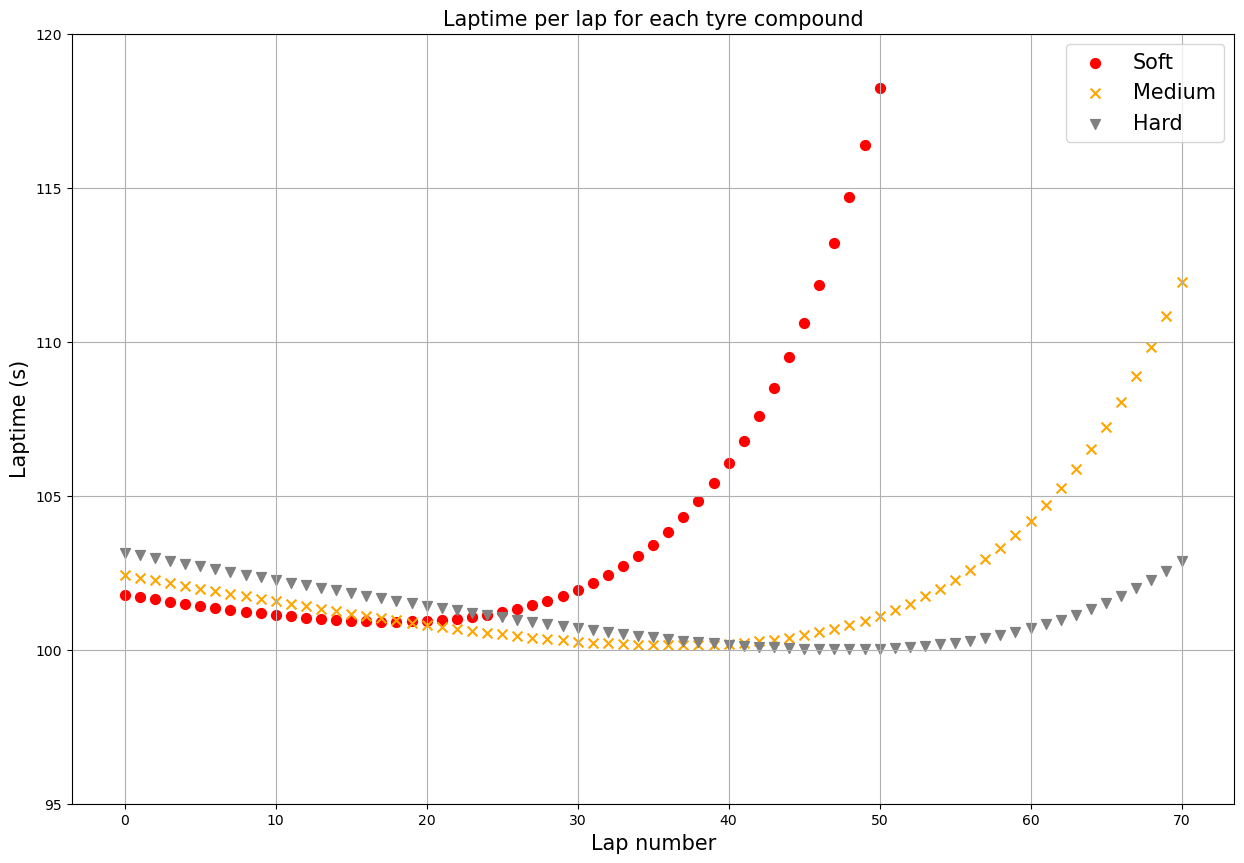

In [288]:
plt.style.use('default')

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(soft_sim['lap'], soft_sim['laptime'], label='Soft', color='red', s=50) 
ax.scatter(medium_sim['lap'], medium_sim['laptime'], label='Medium', color='orange', marker='x', s=50)
ax.scatter(hard_sim['lap'], hard_sim['laptime'], label='Hard', color='grey', marker='v', s=50)
ax.set_xlabel('Lap number', fontsize=15)
ax.set_ylabel('Laptime (s)', fontsize=15)
ax.set_title('Laptime per lap for each tyre compound', fontsize=15)
ax.set_ylim([95, 120])
ax.legend(fontsize=15)
ax.grid(True)
plt.savefig(format='svg', fname='compounds_comparison.svg')
plt.show()

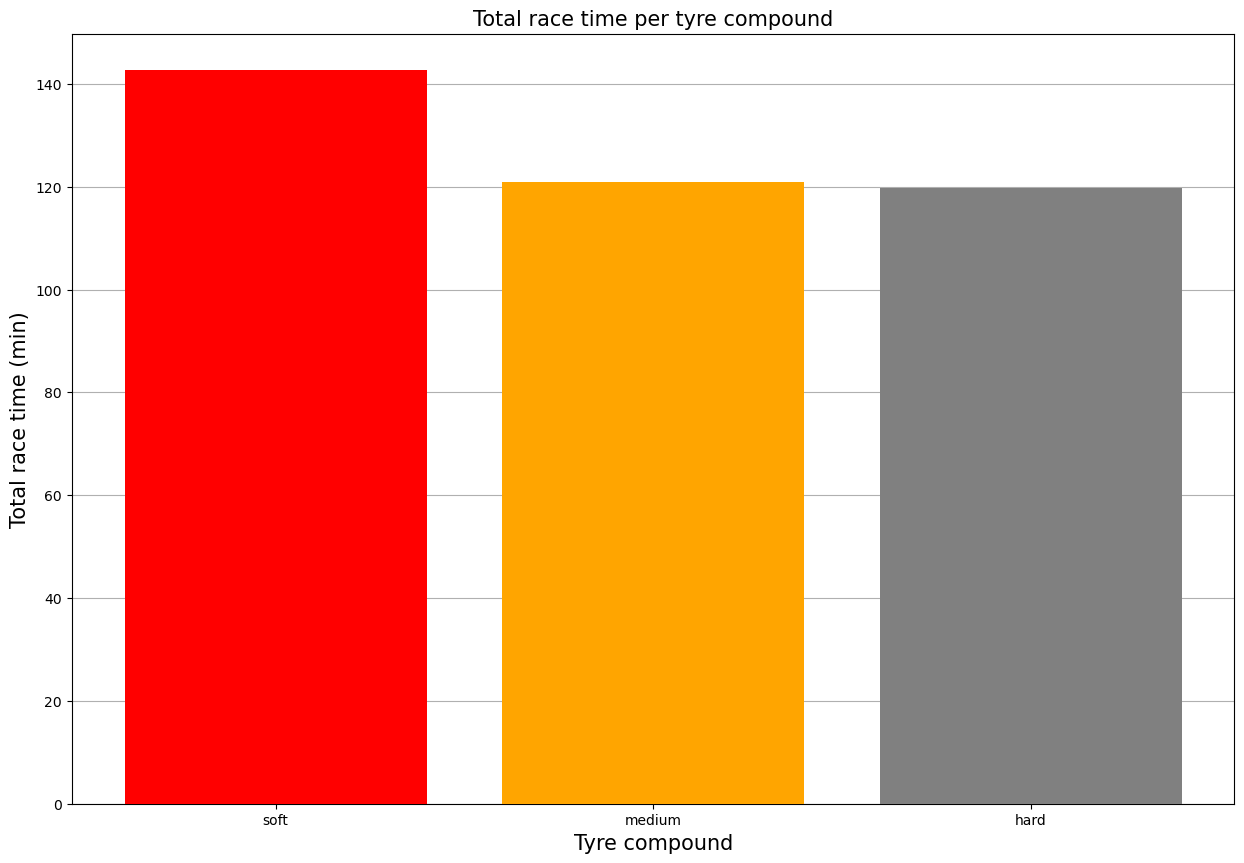

In [289]:
total_race_time = {
    'soft': soft_sim['totaltime'].iloc[-1] / 60,
    'medium': medium_sim['totaltime'].iloc[-1] / 60,
    'hard': hard_sim['totaltime'].iloc[-1] / 60,
}

fig, ax = plt.subplots(figsize=(15, 10))

ax.bar(total_race_time.keys(), total_race_time.values(), color=['red', 'orange', 'grey'], zorder=3)
ax.set_xlabel('Tyre compound', fontsize=15)
ax.set_ylabel('Total race time (min)', fontsize=15)
ax.set_title('Total race time per tyre compound', fontsize=15)
ax.grid(True, axis='y')
plt.savefig(format='svg', fname='compounds_total_race_time.svg')
plt.show()

## Race simulation

In [290]:
def simulate_race(compound, nb_laps=NB_LAPS, starting_fuel=STARTING_FUEL):
    race_simulation = pd.DataFrame(columns=['lap', 'tyre', 'fuel', 'laptime', 'totaltime'])
    race_simulation['lap'] = range(1, nb_laps + 1)
    race_simulation['tyre'] = compound['name']
    race_simulation['fuel'] = starting_fuel - FUEL_USAGE_PER_LAP * race_simulation['lap']
    race_simulation['laptime'] = BASE_LAPTIME + calculate_tyre_delta(compound, race_simulation['lap']) + FUEL_PENALTY_PER_LAP * race_simulation['fuel']
    race_simulation['totaltime'] = race_simulation['laptime'].cumsum()
    return race_simulation

In [291]:
def calculate_race_time_per_strategy(compounds, pit_laps):
    pit_laps = pit_laps + [NB_LAPS]
    total_race_time = 0
    nb_laps_completed = 0
    fuel = STARTING_FUEL
    sim = pd.DataFrame(columns=['lap', 'tyre', 'fuel', 'laptime', 'totaltime'])
    for compound, pit_lap in zip(compounds, pit_laps):
        stint_sim = simulate_race(compound, pit_lap - nb_laps_completed, fuel)
        sim = pd.concat([sim, stint_sim], ignore_index=True)
        nb_laps_completed = pit_lap
        fuel = stint_sim['fuel'].iloc[-1]
        total_race_time += stint_sim['totaltime'].iloc[-1]

    return sim, total_race_time

In [292]:
sim, total_time = calculate_race_time_per_strategy(
    compounds=[COMPOUNDS['soft'], COMPOUNDS['medium']],
    pit_laps=[30]
)

In [293]:
sim.iloc[28:35]

,lap,tyre,fuel,laptime,totaltime
28,29,soft,64.428571,101.749913,2935.111900
29,30,soft,62.857143,101.944047,3037.055947
30,1,medium,61.285714,99.507143,99.507143
31,2,medium,59.714286,99.419257,198.926400
32,3,medium,58.142857,99.331883,298.258283
33,4,medium,56.571429,99.245063,397.503346
34,5,medium,55.000000,99.158839,496.662185


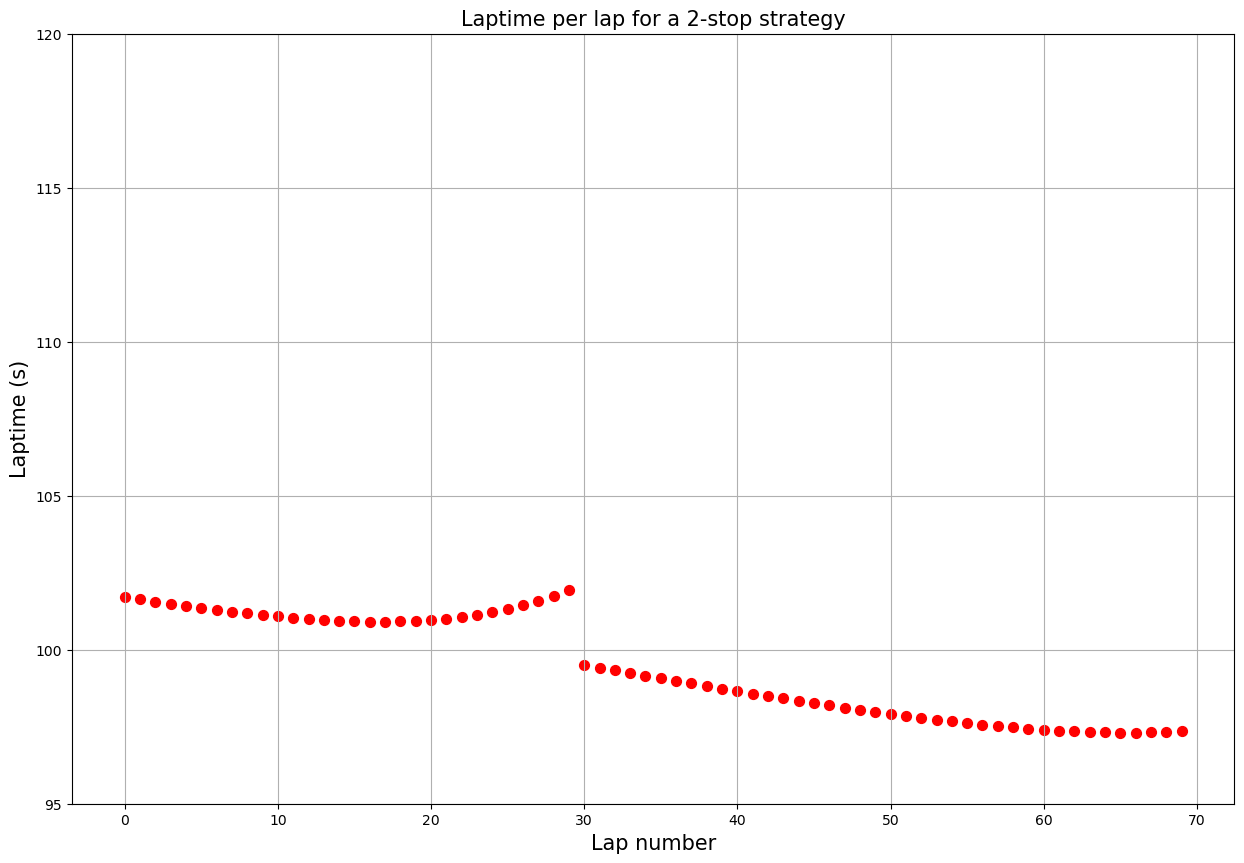

In [294]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(sim.index, sim['laptime'], color='red', s=50)
ax.set_xlabel('Lap number', fontsize=15)
ax.set_ylabel('Laptime (s)', fontsize=15)
ax.set_title('Laptime per lap for a 2-stop strategy', fontsize=15)
ax.set_ylim([95, 120])
ax.grid(True)
#plt.savefig(format='svg', fname='2_stop_strategy.svg')
plt.show()

In [295]:
def calculate_race_time_one_stop(first_stint_compound, second_stint_compound, safety_car_window=[]):
    result = pd.DataFrame(columns=['pitlap', 'totaltime'])
    for pitlap in range(1, NB_LAPS):
        _, total_time = calculate_race_time_per_strategy(
            compounds=[first_stint_compound, second_stint_compound],
            pit_laps=[pitlap]
        )
        if pitlap in safety_car_window:
            total_time += TIME_LOST_IN_PIT_SAFTY_CAR
        else:
            total_time += TIME_LOST_IN_PIT
        result = pd.concat([result, pd.DataFrame({'pitlap': [pitlap], 'totaltime': [total_time]})], ignore_index=True)
    return result

In [296]:
soft_med = calculate_race_time_one_stop(COMPOUNDS['soft'], COMPOUNDS['medium'])
soft_med['totaltime_min'] = soft_med['totaltime'] / 60

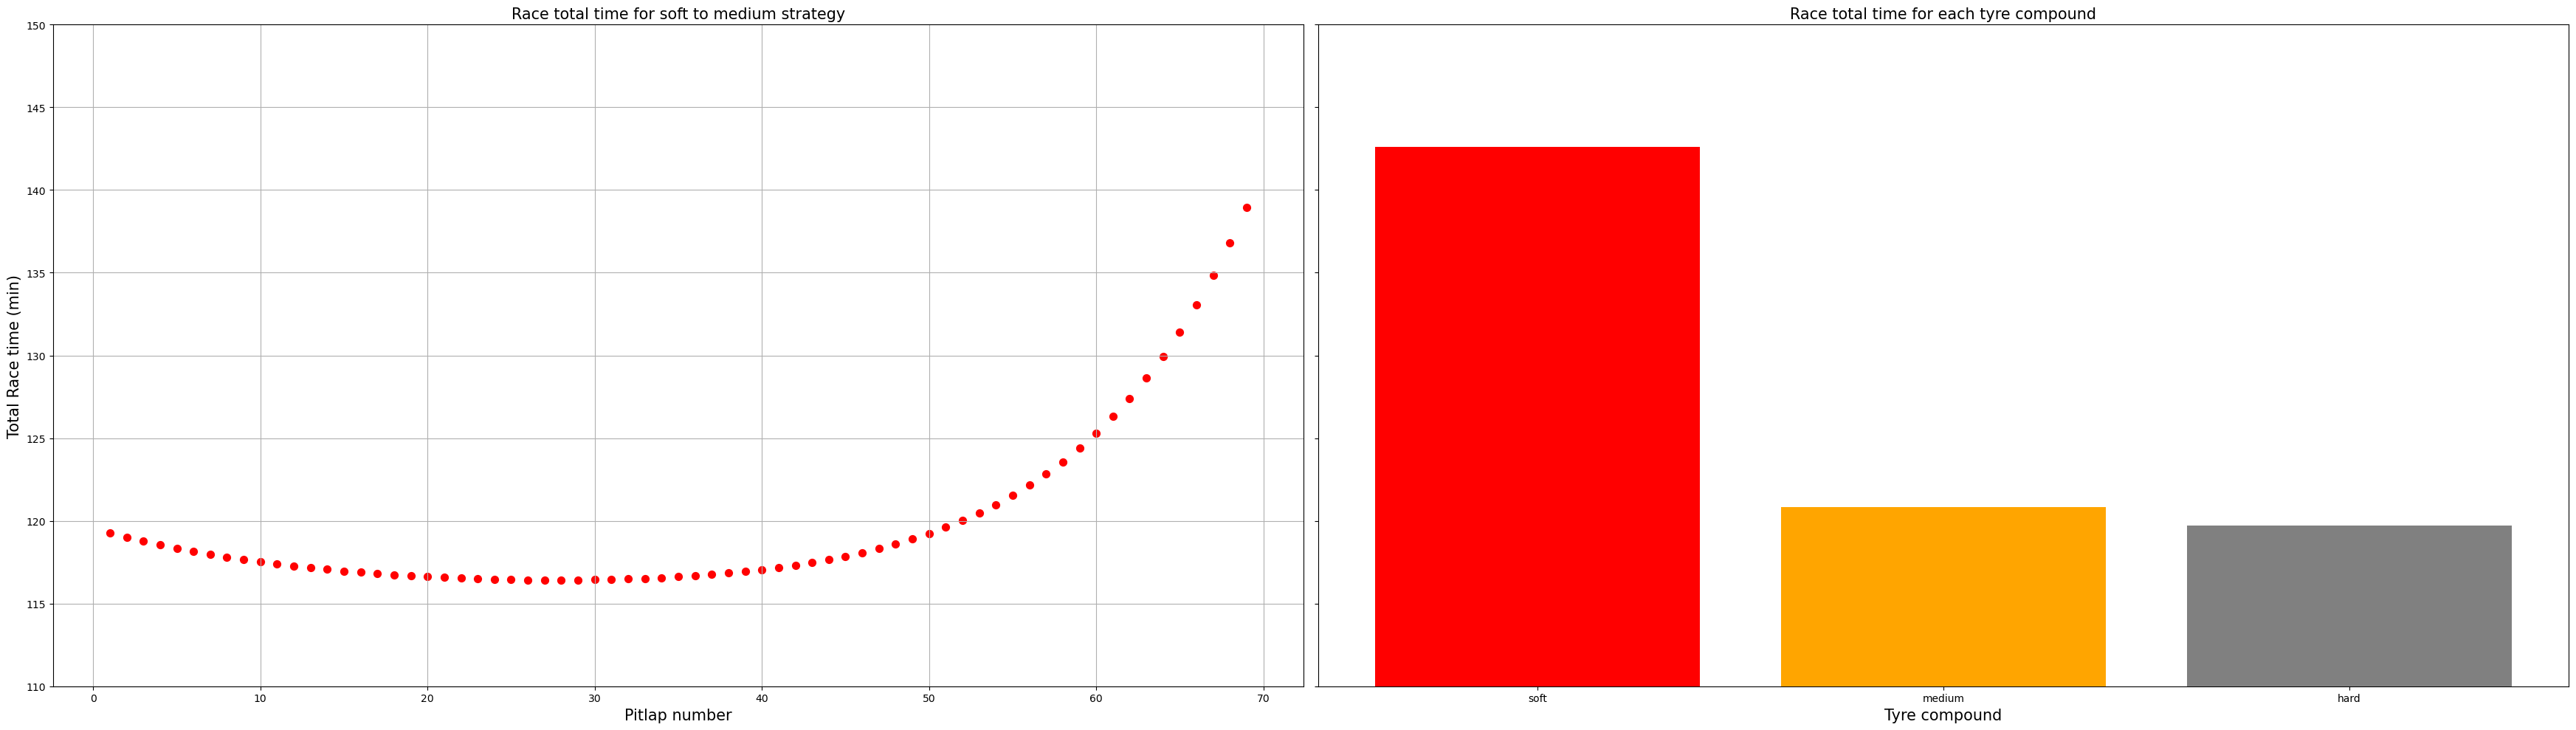

In [297]:
fig, axes = plt.subplots(ncols=2, figsize=(35, 10), sharey=True)
axes[1].bar(total_race_time.keys(), total_race_time.values(), color=['red', 'orange', 'grey'], zorder=3)
axes[0].scatter(soft_med['pitlap'], soft_med['totaltime_min'], color='red', s=50)
axes[0].set_xlabel('Pitlap number', fontsize=15)
axes[0].set_ylabel('Total Race time (min)', fontsize=15)
axes[0].set_ylim([110, 150])
axes[0].set_title('Race total time for soft to medium strategy', fontsize=15)
axes[0].grid(True)
axes[1].set_xlabel('Tyre compound', fontsize=15)
axes[1].set_title('Race total time for each tyre compound', fontsize=15)
fig.tight_layout()
plt.savefig(format='svg', fname='soft_to_medium.svg')
plt.show()

In [298]:
soft_hard = calculate_race_time_one_stop(COMPOUNDS['soft'], COMPOUNDS['hard'])
soft_hard['totaltime_min'] = soft_hard['totaltime'] / 60

med_hard = calculate_race_time_one_stop(COMPOUNDS['medium'], COMPOUNDS['hard'])
med_hard['totaltime_min'] = med_hard['totaltime'] / 60

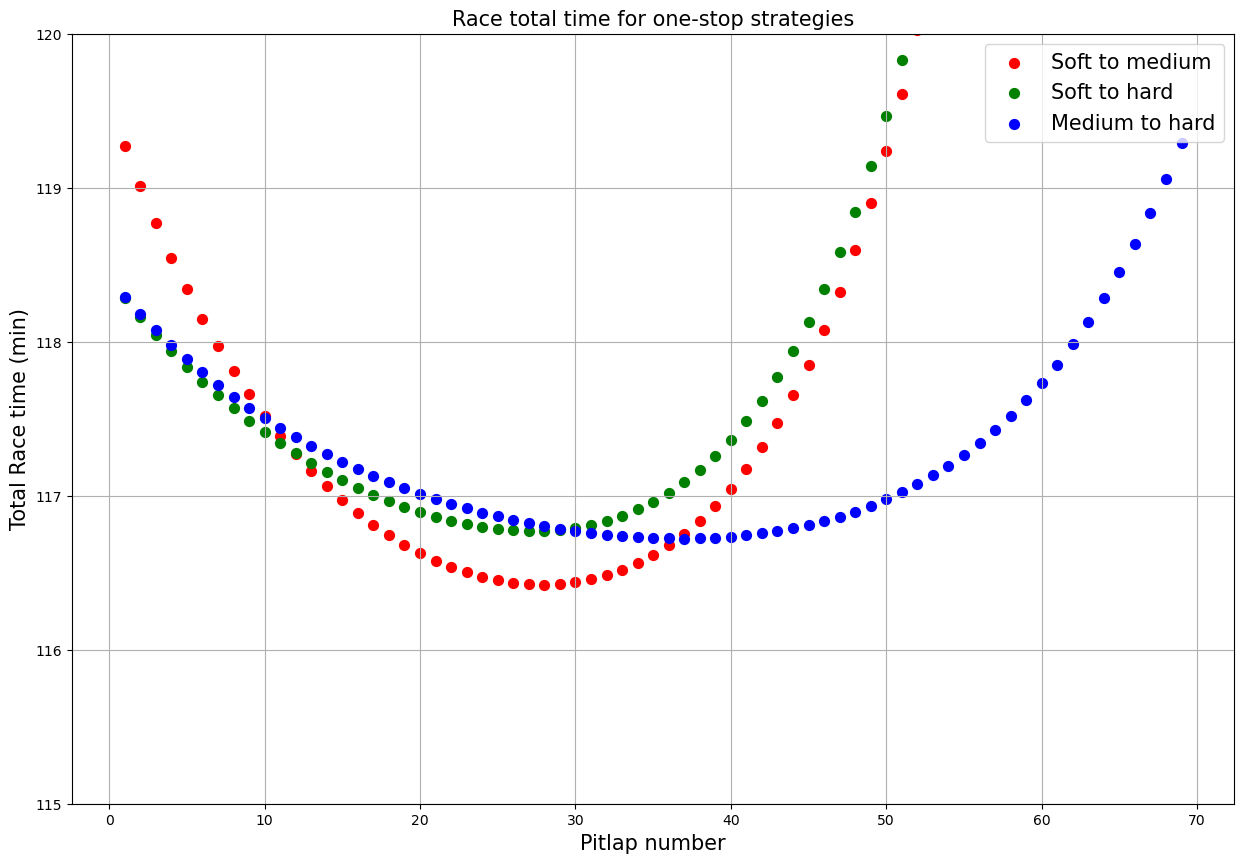

In [299]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(soft_med['pitlap'], soft_med['totaltime_min'], color='red', s=50, label='Soft to medium')
ax.scatter(soft_hard['pitlap'], soft_hard['totaltime_min'], color='green', s=50, label='Soft to hard')
ax.scatter(med_hard['pitlap'], med_hard['totaltime_min'], color='blue', s=50, label='Medium to hard')
ax.set_xlabel('Pitlap number', fontsize=15)
ax.set_ylabel('Total Race time (min)', fontsize=15)
ax.set_ylim([115, 120])
ax.set_title('Race total time for one-stop strategies', fontsize=15)
ax.grid(True)
ax.legend(fontsize=15)
plt.savefig(format='svg', fname='one_stop_strategies.svg')
plt.show()

In [302]:
soft_med = calculate_race_time_one_stop(COMPOUNDS['soft'], COMPOUNDS['medium'], safety_car_window=list(range(18, 23)))
soft_med['totaltime_min'] = soft_med['totaltime'] / 60

soft_hard = calculate_race_time_one_stop(COMPOUNDS['soft'], COMPOUNDS['hard'], safety_car_window=list(range(18, 23)))
soft_hard['totaltime_min'] = soft_hard['totaltime'] / 60

med_hard = calculate_race_time_one_stop(COMPOUNDS['medium'], COMPOUNDS['hard'], safety_car_window=list(range(18, 23)))
med_hard['totaltime_min'] = med_hard['totaltime'] / 60

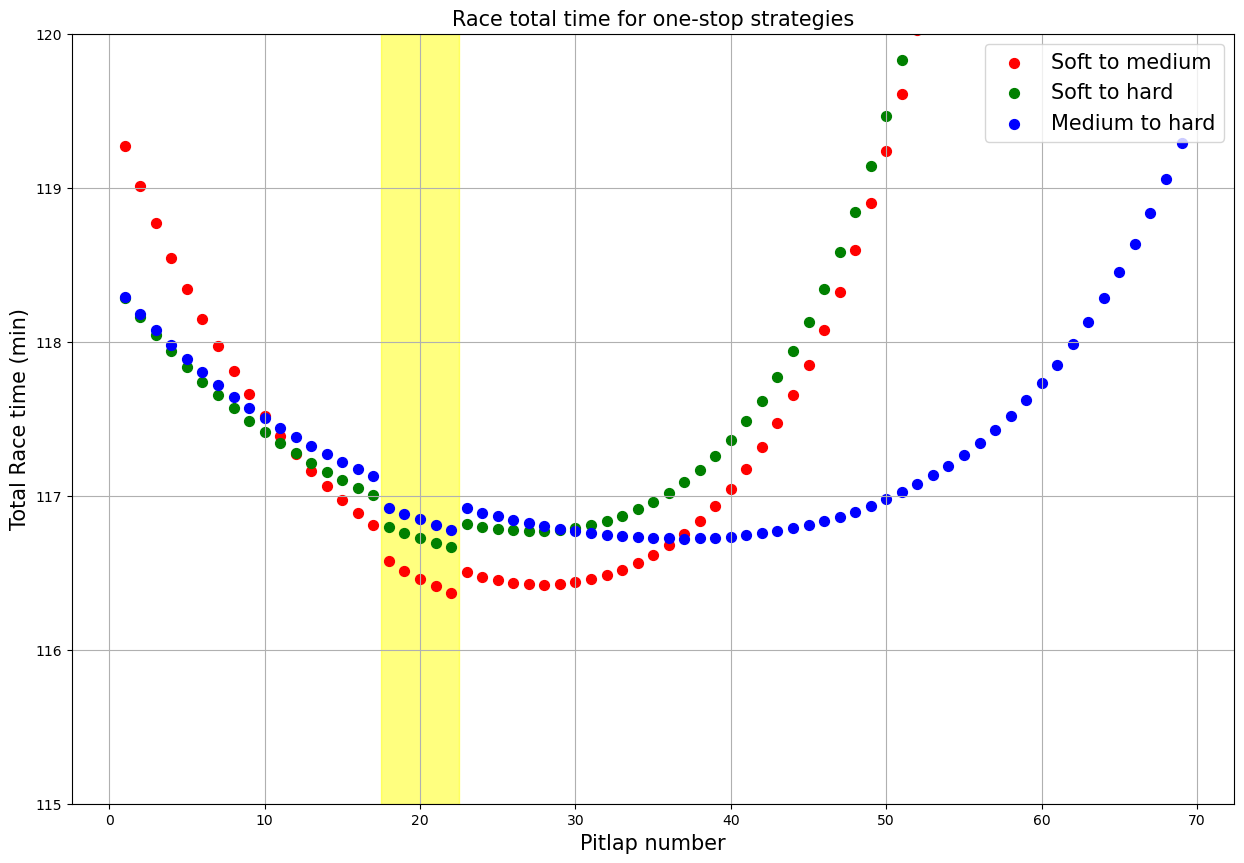

In [303]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.add_patch(
    plt.Rectangle(
        (17.5, 115),
        5,
        5,
        color='yellow',
        alpha=0.5)
)
ax.scatter(soft_med['pitlap'], soft_med['totaltime_min'], color='red', s=50, label='Soft to medium')
ax.scatter(soft_hard['pitlap'], soft_hard['totaltime_min'], color='green', s=50, label='Soft to hard')
ax.scatter(med_hard['pitlap'], med_hard['totaltime_min'], color='blue', s=50, label='Medium to hard')
ax.set_xlabel('Pitlap number', fontsize=15)
ax.set_ylabel('Total Race time (min)', fontsize=15)
ax.set_ylim([115, 120])
ax.set_title('Race total time for one-stop strategies', fontsize=15)
ax.grid(True)
ax.legend(fontsize=15)
plt.savefig(format='svg', fname='one_stop_strategies_safety_car.svg')
plt.show()